In [2]:
import os
import gzip
import pandas as pd

# reading gene list
engs_gene_df = pd.read_csv('matched-gene-list.tsv', sep='\t', usecols=[0, 1])
engs_gene_df.columns = ['gene', 'id']

# reading TCGA files
df = pd.DataFrame()
source_filename = 'gdc_download_20200211_235941.906086'
for root, dirs, files in os.walk(source_filename, topdown=True):
        
    gz_file = [i for i in files if i.endswith('.gz')]
    if not gz_file:
        # print(root, dirs, files)
        continue
    else:
        gz_file = gz_file[0]
        
    for gz in [i for i in files if i.endswith('.gz')]:    
        with gzip.open(os.path.join(root, gz)) as f:

            temp_df = pd.read_csv(f, sep='\t', names=['id_init', 'count'])
            temp_df['id'] = temp_df['id_init'].apply(lambda x: x.split('.')[0])
            temp_df['file_id'] = os.path.split(root)[-1]
            temp_df = temp_df.merge(engs_gene_df, how='inner', on='id')
            if len(temp_df) == 1:
                continue

            df = pd.concat([df, temp_df], axis=0)
    # break
    # print(temp_df.sample())

In [3]:
# metadata_df = pd.read_json('metadata.cart.2020-02-12.json')
# df = df.merge(metadata_df[['associated_entities', 'file_id']], how='inner', on='file_id')

In [4]:
# including project information
sample_df = pd.read_csv('gdc_sample_sheet.2020-02-12.tsv', sep='\t')
sample_df.columns = [i.lower().replace(' ', '_') for i in list(sample_df)]
df = df.merge(sample_df[['project_id', 'case_id', 'sample_id', 'sample_type', 'file_id']], how='inner', on='file_id')

In [7]:
# saving processed data to save time not reading everything from scratch
# df.to_csv('proccessed_data.csv')
import pandas as pd
df = pd.read_csv('proccessed_data.csv')
df.head()

,Unnamed: 0,id_init,count,id,file_id,gene,project_id,case_id,sample_id,sample_type
0,0,ENSG00000012048.18,411,ENSG00000012048,0bf50119-afec-41f8-8b89-262dfb8c3a53,BRCA1,TCGA-BRCA,TCGA-GI-A2C8,TCGA-GI-A2C8-11A,Solid Tissue Normal
1,1,ENSG00000051180.15,44,ENSG00000051180,0bf50119-afec-41f8-8b89-262dfb8c3a53,RAD51,TCGA-BRCA,TCGA-GI-A2C8,TCGA-GI-A2C8-11A,Solid Tissue Normal
2,2,ENSG00000100462.14,2647,ENSG00000100462,0bf50119-afec-41f8-8b89-262dfb8c3a53,PRMT5,TCGA-BRCA,TCGA-GI-A2C8,TCGA-GI-A2C8-11A,Solid Tissue Normal
3,3,ENSG00000139618.13,46,ENSG00000139618,0bf50119-afec-41f8-8b89-262dfb8c3a53,BRCA2,TCGA-BRCA,TCGA-GI-A2C8,TCGA-GI-A2C8-11A,Solid Tissue Normal
4,4,ENSG00000166483.9,1250,ENSG00000166483,0bf50119-afec-41f8-8b89-262dfb8c3a53,WEE1,TCGA-BRCA,TCGA-GI-A2C8,TCGA-GI-A2C8-11A,Solid Tissue Normal


In [ ]:
# generating log values of expressions for each project
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

# generating log values of expressions for each project
df['count_log'] = df['count'].apply(lambda x: pd.np.log(x))

# plotting grid of box plots for each prject and sample type
g = sns.FacetGrid(df, row="project_id", col="sample_type", margin_titles=True)
g.map(sns.boxplot, "gene", "count_log")
# fig = g.get_figure()
# fig.savefig('boxplot.png') 

# obtaining individual box plots
for project in set(df['project_id']):
    temp_df = df.loc[df['project_id'] == project]
    title = project + str(len(set(temp_df['sample_id'])))
    # sns.boxplot(x="gene", y="count_log", data=temp_df, hue="sample_type").set_title(title)
    break

<ipython-input-43-8337712d758f>:5: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  foo['count'] = foo['count'].apply(lambda x: round(pd.np.log(x), 2))


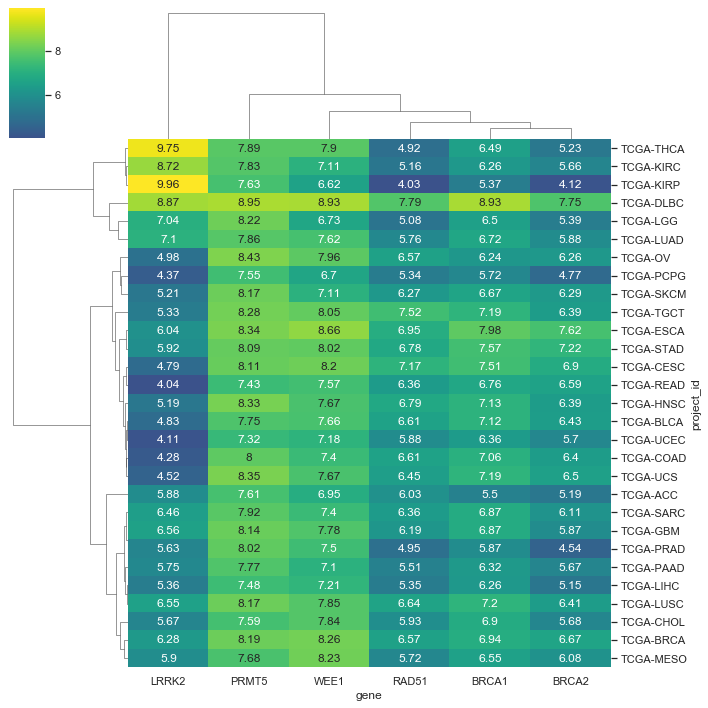

In [43]:
# cluster map of expression levels for Primary Tumor sample type
sample_type = 'Primary Tumor' # change this to visualize different sample types
cancer_df = df.loc[df['sample_type'] == sample_type]
foo = cancer_df.groupby(['project_id', 'gene'], as_index=False)['count'].median()
foo['count'] = foo['count'].apply(lambda x: round(pd.np.log(x), 2))

result = foo.pivot(index='project_id', columns='gene', values='count')
sns.clustermap(result, annot=True, fmt="g", cmap='viridis', center=6, metric="correlation")
plt.show()

In [ ]:
# corrolation of genes in cancer samples in different projects plotted as individual heatmaps
df1 = pd.pivot_table(
    df.loc[df['sample_type'] == 'Primary Tumor'],
    index=['project_id','sample_id'], 
    columns='gene',
    values='count', 
    fill_value=0
)
df1.reset_index(inplace=True)

for project in set(df['project_id']):
    temp_df = df1.loc[df1['project_id'] == project]
    # print(temp_df.corr(method='pearson'))
    corr_df = temp_df.corr(method='pearson')
    
    mask = pd.np.triu(pd.np.ones_like(corr_df, dtype=pd.np.bool))
    with sns.axes_style("white"):
        f, ax = plt.subplots(figsize=(7, 5))
        ax = sns.heatmap(corr_df, mask=mask, square=True, annot=True, vmin=-1, vmax=1).set_title(project)
    break

TCGA-SARC number of measurements 43
BRCA1 (0.134460058069758, 0.38998455586581354)
BRCA2 (0.3367814511071871, 0.027223140527022457)
PRMT5 (0.007136192043116604, 0.9637751243540958)
RAD51 (-0.06406346869289099, 0.6831759826168556)
WEE1 (0.36578562489225935, 0.015857029757165422)
-
TCGA-COAD number of measurements 71
BRCA1 (0.2805855210860999, 0.017782563515967797)
BRCA2 (0.19145432608329707, 0.10972685605359085)
PRMT5 (0.10877832176562915, 0.3665277194207276)
RAD51 (0.09543436003668115, 0.4285472857626699)
WEE1 (0.2979269884642507, 0.011622459102264619)
-
TCGA-STAD number of measurements 80
BRCA1 (0.15303992325178842, 0.17532643325094271)
BRCA2 (-0.032257575875673974, 0.7763693314523389)
PRMT5 (-0.03813423708063393, 0.7369937601692206)
RAD51 (-0.038388194552242114, 0.7353065107588347)
WEE1 (0.2338316136315779, 0.03683643356115576)
-
TCGA-ACC number of measurements 4
BRCA1 (0.9662514818052805, 0.03374851819471947)
BRCA2 (0.8964832725898122, 0.1035167274101878)
PRMT5 (0.7932086666056999, 

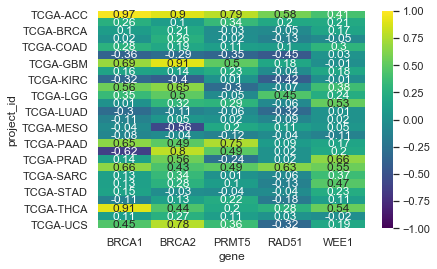

In [73]:
from scipy.stats import pearsonr, spearmanr

# show just genes correlations with LRRK2 in a heatmap
final_df = pd.DataFrame()
for project in set(df['project_id']):
    temp_df = df1.loc[df1['project_id'] == project]
    
    if len(temp_df['LRRK2']) <= 1:
        print('Project', project, 'does not have enough samples.')
        continue
    # show correlation score, p value and scatter plot
    print(project, 'number of measurements', len(temp_df['LRRK2']))
    for i in ['BRCA1', 'BRCA2', 'PRMT5', 'RAD51', 'WEE1']:
        print(i, pearsonr(temp_df['LRRK2'], temp_df[i]))
        # temp_df.plot(x='LRRK2', y=i, style='o')
    print('-')
        
    corr_df = temp_df.corr(method='pearson')
    corr_df['project_id'] = project
    corr_df.reset_index(inplace=True)
    corr_df = corr_df[['LRRK2', 'project_id', 'gene']]
    final_df = pd.concat([final_df, corr_df])

# creaes a heatmap
final_df['LRRK2'] = final_df['LRRK2'].apply(lambda x: round(x, 2))
piv_df = final_df.pivot(index='project_id', columns='gene', values='LRRK2')
piv_df.drop(['LRRK2'], axis=1, inplace=True)
sns.heatmap(piv_df, vmin=-1, vmax=1, annot=True, fmt="g", cmap='viridis')
plt.show()

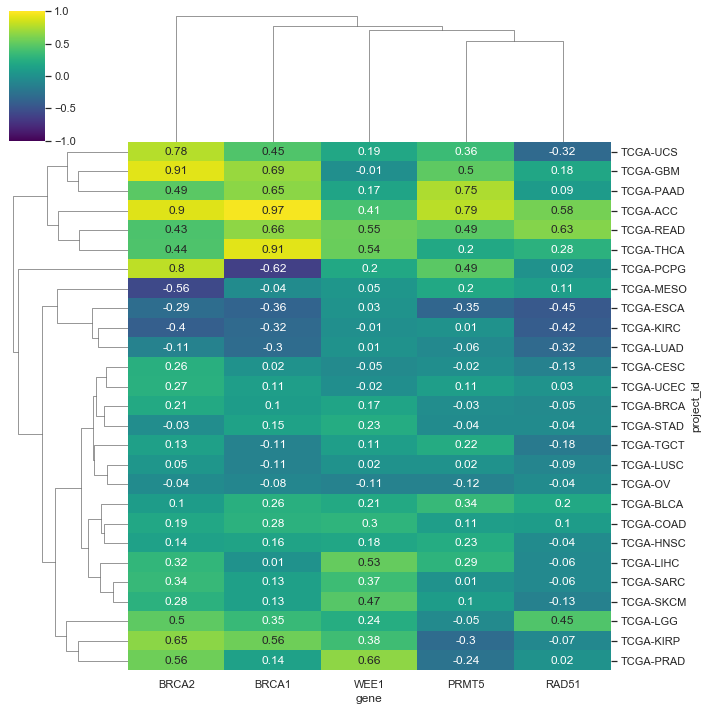

In [46]:
# cluster map for corrolation of genes with LRRK2 for every project in Primary Tumor sample type
piv_df.dropna(axis=0, inplace=True)
sns.clustermap(piv_df, vmin=-1, vmax=1, annot=True, fmt="g", cmap='viridis')
plt.show()